In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# set the parameters for the astxfe 90 grid
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1 + nx + ncut2
nz = 50
nfx = np.array([nx,0,nx,ncut2,ncut1])
nfy = np.array([ncut1, 0, nx,nx,nx])

In [3]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = layers_path + "diags/BUDG/"
dirstate = layers_path + "diags/STATE/"

In [4]:
# 126-130
xc = mygrid['XC']
yc = mygrid['YC']
rac = mygrid['RAC']
drf = mygrid['DRF']

In [5]:
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1+nx+ncut2   # this is 450
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','maskInC','DXG','DYG']#,'DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF','RF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

# mygrid['mskC'][mygrid['mskC'] == 0] = np.nan
RAC = mygrid['RAC']
mskC = mygrid['maskInC']

In [6]:
hf_aste = get_aste_tracer(hf1[0],nfx,nfy)

In [7]:
d = rdmds(dirgrid + "Depth",-1)
d = np.reshape(d,(ny,nx))
class structtype():
    pass
fld = d
print(fld.shape)
dep_aste = get_aste_tracer(d,nfx,nfy)
dep_compact = aste_tracer2compact(dep_aste,nfx,nfy)
np.sum(d-dep_compact)  # this should be 0 if we did the back and forth correctly

(450, 90)


0.0

In [8]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z
# hf1 = hf1[np.newaxis,:, :]
print(hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)[0]
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

(450, 90)
(50, 450, 90) (450, 90)


In [9]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

In [10]:
# 2d
rac2d = read_float64(dirgrid + "RAC" + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgrid + "DRF" + ".data")


rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat

hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (40500,)
(100,)


In [11]:
# we're not using iWetC2d because I'm not sure where this went for the ASTE 90 grid
ts = "0000000003"
tsstr = np.array([ts])

In [12]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [13]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

In [14]:
ind = ind.reshape(ny,nx)


mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [15]:
ysmsk,xsmsk = np.where(mymsk==1)[0],np.where(mymsk==1)[1]
# np.nanmax(ysmsk)

In [16]:
tsstr = np.array(['0000000002','0000000003'])
RAC3 = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))
hfC = mygrid['hFacC']

DD = mygrid['Depth']

DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))


In [17]:
LwetC2d = np.count_nonzero(mygrid['hFacC'][0])

In [18]:
mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

iwet_mine = np.where(~np.isnan(mymsk_1d))
iwet_mine[0].shape
iwet_mine = iwet_mine[0]

In [20]:

setTS_Stend=parsemeta(layers_path + "diags/LAYERS/layers_TSjoint_Stend_set1.0000000003.meta")["fldList"]
setTS_Stend

['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'LSha_TS', 'LSza_TS', 'LSto_TS']

In [21]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jx = {}
# set each basin to its own dictionary
Jx[name] = {}
Jx[name]['G_S'] = {}
Jx[name]['G_S']['residS'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Stend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = layers_path + "diags/LAYERS/layers_TSjoint_Stend_set1" + "." + tsstr[-1] + ".data"
    tmp = read_float64_skip(filename, LwetC2d*(nS-1)*(nT-1),i)   
    print(tmp.shape)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))  # m/s
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac   # Sv

    # if at end of loop
    if i == len(setTS_Stend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthT1)

    # double check the names in the listed file
    if i == len(setTS_Stend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i in {0,1,2,3,4}:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp
    tmp1 = np.nansum(tmp[:,:,iwet_mine],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthT1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jx[name][setTS_Stend[i]] = tmp1
    Jx[name]['G_S'][setTS_Stend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2

(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)


In [29]:
layers_path

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/'

In [22]:
# check the lists

# set 1 - the total terms we want for the budget
setTS_Ttend=parsemeta(layers_path + "diags/LAYERS/layers_TSjoint_Ttend_set1.0000000003.meta")["fldList"]

# set 2 - the other terms
setTS_Ttend_set2=parsemeta(layers_path + "diags/LAYERS/layers_TSjoint_Ttend_set2.0000000003.meta")["fldList"]

In [61]:
setTS_Ttend

['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'LTha_TS', 'LTza_TS', 'LTto_TS']

In [23]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
Jy[name] = {}
Jy[name]['G_T'] = {}
Jy[name]['G_T']['residT'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Ttend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = layers_path + "diags/LAYERS/layers_TSjoint_Ttend_set1" + "." + tsstr[-1] + ".data"
    tmp = read_float64_skip(filename, LwetC2d*(nS-1)*(nT-1),i)   # m/s
    print(tmp.shape)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d    # m^2
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac  # Sv

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthS1)

    # double check the names in the listed file
    if i == len(setTS_Ttend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i in {0,1,2,3,4}:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp
    tmp1 = np.nansum(tmp[:,:,iwet_mine],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jy[name][setTS_Ttend[i]] = tmp1
    Jy[name]['G_T'][setTS_Ttend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2


(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)


In [24]:
# get the convergence with the layers to see if this is the same as what we achieve with the J terms

In [25]:
setTS_Ttend

['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'LTha_TS', 'LTza_TS', 'LTto_TS']

In [26]:
setTS_Stend

['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'LSha_TS', 'LSza_TS', 'LSto_TS']

In [28]:
Jx_adv = Jx[name]['LaSh_TS']
Jy_adv = Jy[name]['LaTh_TS']    # should be both in Sv currently - check if this makes sense

In [31]:
Tbin,Sbin = np.meshgrid(binsTH_centers,binsSLT_centers)

(-2.0, 10.0)

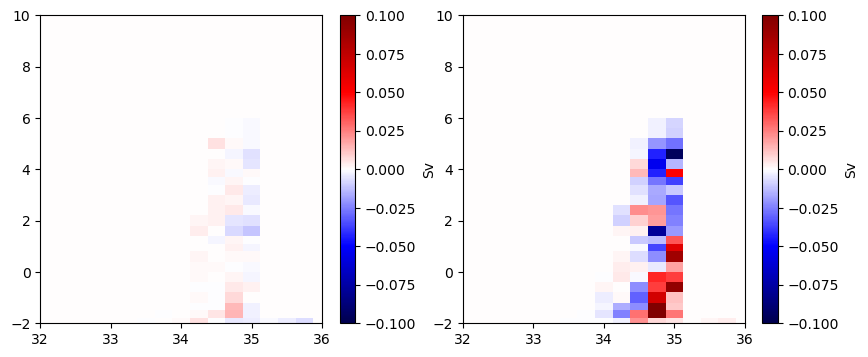

In [38]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,Jx_adv,cmap='seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb,label="Sv")
ax.set_xlim(32,36)
ax.set_ylim(-2,10)


ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,Jy_adv,cmap='seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb,label="Sv")
ax.set_xlim(32,36)
ax.set_ylim(-2,10)

In [40]:
# get the convergence of these terms and plot them as we did before
binwidthT1tile = np.tile(binwidthT1[np.newaxis,:],(nT-1,1))
binwidthS1tile = np.tile(binwidthS1[:,np.newaxis],(1,nS-1))

In [81]:
def calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile, bc="zero"):
    """
    Compute convergence in TS space with same-shape output.
    JtermsS, JtermsT: arrays shaped (nterms, nS, nT)
    binwidthS1tile, binwidthT1tile: broadcastable to (nS, nT)
    bc: "zero" (default) or "periodic"
    """
    conv = np.zeros_like(JtermsS)
    convUa = np.zeros_like(JtermsS)
    convVa = np.zeros_like(JtermsS)
    nterms = JtermsS.shape[0]

    for i in range(nterms):
        JS = JtermsS[i]  # flux along S-axis   m^3/s/degC
        JT = JtermsT[i]  # flux along T-axis   m^3/s/PSU

        # same-shape arrays
        convU = np.zeros_like(JS)
        convV = np.zeros_like(JT)

        # interior differences (lose one neighbor, keep shape by assigning into interior)
        convU[:, :-1] = JS[:, :-1] - JS[:, 1:]      # d/dS of S-flux
        convV[:-1, :] = JT[:-1, :] - JT[1:, :]      # d/dT of T-flux

        convU[:, -1] = 0.0
        convV[-1, :] = 0.0

        # normalize by bin widths (broadcasts)
        convU = convU * binwidthS1tile * binwidthT1tile       # m/s/degC/PSU
        convV = convV * binwidthT1tile * binwidthS1tile      # m/s/PSU/degC

        # total convergence for this term
        conv[i] = convU + convV
        convUa[i] = convU
        convVa[i] = convV

    return conv,convUa,convVa

TSconv,convU,convV = calc_UV_conv_TS(Jx_adv.reshape(1,111,111), Jy_adv.reshape(1,111,111), binwidthS1tile, binwidthT1tile)

In [77]:
np.nanmean(binwidthS1 * binwidthT1)

0.13344594608019064

(-2.0, 10.0)

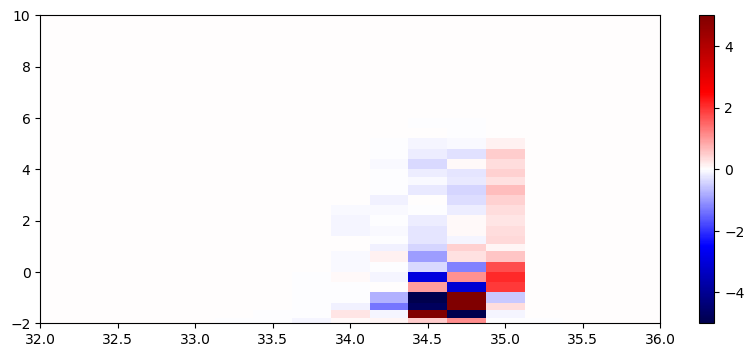

In [83]:
plt.pcolormesh(Sbin,Tbin,-TSconv[0],cmap='seismic',vmin=-5,vmax=5)
plt.colorbar()
plt.xlim(32,36)
plt.ylim(-2,10)

In [57]:
# try this again with the sum of the terms

Jx_adv = np.zeros((nT-1,nS-1))
for item in (setTS_Stend[:-1]):
    if item != "LSha_TS" and item != "LSza_TS":
        get = Jx[name][item]
        Jx_adv += get

Jy_adv = np.zeros((nT-1,nS-1))
for item in (setTS_Ttend[:-1]):
    if item != "LTha_TS" and item != "LTza_TS":
        get = Jy[name][item]
        Jy_adv += get

In [58]:
TSconv,convU,convV = calc_UV_conv_TS(Jx_adv.reshape(1,111,111), Jy_adv.reshape(1,111,111), binwidthS1tile, binwidthT1tile)

(-2.0, 10.0)

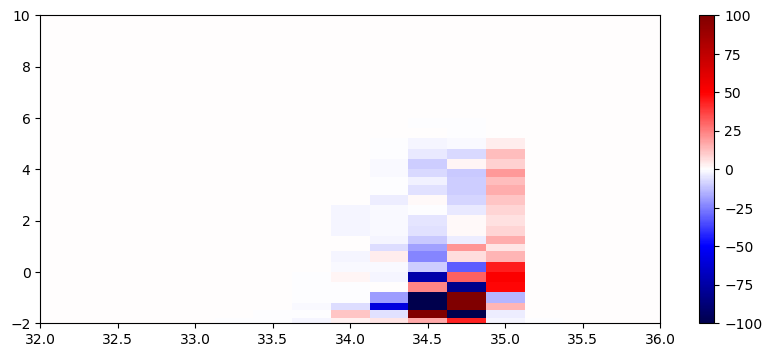

In [60]:
plt.pcolormesh(Sbin,Tbin,-TSconv[0],cmap='seismic',vmin=-100,vmax=100)
plt.colorbar()
plt.xlim(32,36)
plt.ylim(-2,10)

In [ ]:
# we should also test (in the other notebook maybe) that this is the same thing we achieve with offline